# Generic functions

In [146]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [147]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.signal import butter, savgol_filter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import keras.layers as L
import tensorflow as tf
from sklearn import linear_model
from keras import callbacks
import keras.models as M
import keras.backend as K
import keras.optimizers as O
from keras.callbacks import ModelCheckpoint

%matplotlib inline
np.random.seed(103)

In [148]:
# Custom metric function to compute the RMSE.
def rmse(ytrue,ypred):
    tf.reshape(ytrue,[-1,1])
    tf.reshape(ypred,[-1,1])
    return K.sqrt(K.mean(K.square(ytrue - ypred),axis=-1))

In [149]:
def create_time_stepped_data(df, time_steps,num_features):
    d = []
    for i in range(time_steps):
        d.append(df.shift(-i).values[:-time_steps].reshape(-1,num_features+1))
    return np.transpose(np.array(d),(1,0,2))

In [150]:
def create_formatted_data(df, time_steps, num_features, fut_type=1):
    assert (time_steps%2 !=0), "Time steps should be odd!"
    d = create_time_stepped_data(df, time_steps, num_features)
    
    past = d[:,:int(time_steps/2),:]
    if(fut_type == 1):
        fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    else:
        fut = np.flip(d[:,:int(time_steps/2),:],1)
    y = d[:,int(time_steps/2),-1]
    if(num_features == 0):
        cur = np.zeros((d.shape[0],1,256))
    else:
        cur = d[:,int(time_steps/2),:-1]
        cur = np.dstack((cur.reshape(-1,1,num_features),np.zeros(shape=(d.shape[0],1,256-num_features))))
    return past,fut,y

In [151]:
def train_test_split(past,fut,y,df):
    train_split = int(0.8*y.shape[0])
    
    #'df' is a pd series.
#     mx = df.iloc[:train_split].max()
#     mn = df.iloc[:train_split].min()
    
#     return (past[:train_split]-mn)/(mx-mn), (past[train_split:]-mn)/(mx-mn), (fut[:train_split]-mn)/(mx-mn), np.zeros_like(past[train_split:]), y[:train_split], y[train_split:]
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), y[:train_split], y[train_split:]

In [152]:
def distributed_lstm_model(input_shape1, input_shape2, loss = 1):
    
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    
    cnn1 = L.Conv1D(filters=256,kernel_size=5)(past_inp)
    cnn1 = L.Conv1D(filters=256,kernel_size=2)(cnn1)
    cnn1 = L.Dense(256)(cnn1)
    cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
        
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(cnn1)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.2)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.2)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out1 = L.Dropout(0.2)(x1)
    lstm_out1 = L.Concatenate(axis=1)([cnn1,lstm_out1])
    
    cnn2 = L.Conv1D(filters=256,kernel_size=5)(fut_inp)
    cnn2 = L.Conv1D(filters=256,kernel_size=2)(cnn2)
    cnn2 = L.Dense(256)(cnn2)
    cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
        
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(cnn2)
    x2 = L.Dense(516)(x2)
    x2 = L.Dropout(0.2)(x2)
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x2)
    x2 = L.Dense(516)(x2)
    x2 = L.Dropout(0.2)(x2)
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x2)
    x2 = L.Dense(256)(x2)
    x2 = L.advanced_activations.LeakyReLU(0.2)(x2)
    lstm_out2 = L.Dropout(0.2)(x2)
    lstm_out2 = L.Concatenate(axis=1)([cnn2,lstm_out2])
    
    x = L.Average()([lstm_out1,lstm_out2])
    x = L.Flatten()(x)
    
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1)(x)
    main_out = L.advanced_activations.LeakyReLU(0.2)(x)
    
    model = M.Model(inputs=[past_inp, fut_inp], outputs=[main_out], name='CLDNN') 
    model.summary()
    if(loss == 1):
        model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae',rmse])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model    

In [153]:
def common_lstm_model(input_shape1, input_shape2, loss=1):
    
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    
    cnn1 = L.Conv1D(filters=256,kernel_size=5)(past_inp)
    cnn1 = L.Conv1D(filters=256,kernel_size=3)(cnn1)
    cnn1 = L.Dense(256)(cnn1)
    cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn2 = L.Conv1D(filters=256,kernel_size=5)(fut_inp)
    cnn2 = L.Conv1D(filters=256,kernel_size=3)(cnn2)
    cnn2 = L.Dense(256)(cnn2)
    cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
    
    lstm_inp = L.Concatenate(axis=1)([cnn1,cnn2])
    
    x1 = L.LSTM(256, unroll=True, recurrent_dropout=0.2, return_sequences=True)(lstm_inp)
    x1 = L.Dense(128)(x1)
    x1 = L.Dropout(0.3)(x1)
    x1 = L.LSTM(256, unroll=True, recurrent_dropout=0.2, return_sequences=True)(x1)
    x1 = L.Dense(128)(x1)
    x1 = L.Dropout(0.3)(x1)
    x1 = L.LSTM(256, unroll=True, recurrent_dropout=0.2, return_sequences=True)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = L.Dropout(0.3)(x1)
    
    x1 = L.Concatenate(axis=1)([lstm_out,lstm_inp])
    x1 = L.Flatten()(x1)
    
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(int(1024/2))(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    main_out = L.Dense(1)(x1)
    model = M.Model(inputs=[past_inp,fut_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    if(loss == 1):
        model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae',rmse])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model

In [154]:
def linear_regression(model_pred, data):
    lin_model = linear_model.LinearRegression()
    split = int(0.7 * data.shape[0])
    training_data_x, training_data_y = model_pred[:split], data[:split]
    testing_data_x, testing_data_y = model_pred[split:], data[split:]
    lin_model.fit(training_data_x, training_data_y)
    lin_model_pred = lin_model.predict(testing_data_x)
    print("MAE %.4f\nR2 %.4f\nRMSE %.4f"%(mean_absolute_error(testing_data_y,lin_model_pred), r2_score(testing_data_y,lin_model_pred),np.sqrt(mean_squared_error(testing_data_y,lin_model_pred))))
    return lin_model

# Distributed LSTM results for all datasets

## NYC Load Data

In [8]:
data = pd.read_csv("NYC Load Data.csv")[-4000:]

In [9]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [10]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 6366 samples, validate on 1592 samples
Epoch 1/20
6366/6366 [==============================] - 152s 24ms/step - loss: 10559.7931 - mean_absolute_error: 10560.2931 - val_loss: 15760.7569 - val_mean_absolute_error: 15761.2569
Epoch 2/20
6366/6366 [==============================] - 141s 22ms/step - loss: 3237.6821 - mean_absolute_error: 3238.1821 - val_loss: 13753.7254 - val_mean_absolute_error: 13754.2254
Epoch 3/20
6366/6366 [==============================] - 140s 22ms/step - loss: 4253.7017 - mean_absolute_error: 4254.2016 - val_loss: 17978.7034 - val_mean_absolute_error: 17979.2034
Epoch 4/20
6366/6366 [==============================] - 119s 19ms/step - loss: 3151.8722 - mean_absolute_error: 3152.3720 - val_loss: 15162.7869 - val_mean_absolute_error: 15163.2869
Epoch 5/20
6366/6366 [==============================] - 107s 17ms/step - loss: 3125.7916 - mean_absolute_error: 3126.2915 - val_loss: 17819.6618 - val_mean_absolute_error: 17820.1618
Epoch 6/20
6366/6366 [=============

In [26]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))*2.7
test = y_test.reshape((-1,))[-100:]

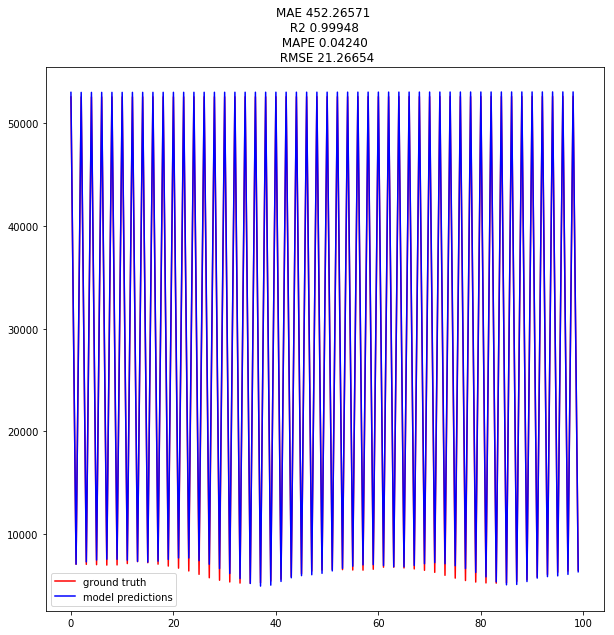

In [27]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Jena Weather Data

In [11]:
data = pd.read_csv("Jena_time_series_data.csv")['T (degC)'][-2000:]
data.reset_index(drop=True,inplace=True)

In [12]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features, fut_type=2)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [13]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       1536        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 35s 22ms/step - loss: 2.4921 - mean_absolute_error: 2.8914 - val_loss: 2.7075 - val_mean_absolute_error: 3.1000
Epoch 2/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.0835 - mean_absolute_error: 0.3059 - val_loss: 2.5613 - val_mean_absolute_error: 2.9815
Epoch 3/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.0585 - mean_absolute_error: 0.2606 - val_loss: 2.4971 - val_mean_absolute_error: 2.9322
Epoch 4/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.0742 - mean_absolute_error: 0.2784 - val_loss: 2.1737 - val_mean_absolute_error: 2.5987
Epoch 5/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.1785 - mean_absolute_error: 0.4703 - val_loss: 2.5663 - val_mean_absolute_error: 3.0156
Epoch 6/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.0588 - mean_absolute_error: 0.264

KeyboardInterrupt: 

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Zuerich Sunspot Data 

In [ ]:
data = pd.read_csv("monthly-sunspot-number-zurich-17.csv")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Petroleum Weekly prices Data

In [ ]:
data = pd.read_csv("petroleumWeeklyPrices.csv")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Monthly car sales Data

In [ ]:
data = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Wolfer Sunspot Data

In [ ]:
data = pd.read_csv("wolfer-sunspot-numbers-1770-to-1.csv")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Daily Minimum temperature Data

In [ ]:
data = pd.read_csv("daily_minimum")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

# Combined LSTM for all Datasets

## NYC Load Data

In [13]:
data = pd.read_csv("NYC Load Data.csv")

In [64]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [65]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
history_callback = model.fit([past_train, fut_train], y_train, epochs=30, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 6, 256)       1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 6, 256)       1536        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_22 

Train on 42045 samples, validate on 10512 samples
Epoch 1/30
42045/42045 [==============================] - 101s 2ms/step - loss: 568.1482 - mean_absolute_error: 568.6480 - rmse: 568.6480 - val_loss: 2593.8679 - val_mean_absolute_error: 2594.3679 - val_rmse: 2594.3678
Epoch 2/30
42045/42045 [==============================] - 93s 2ms/step - loss: 306.6189 - mean_absolute_error: 307.1185 - rmse: 307.1185 - val_loss: 3121.1345 - val_mean_absolute_error: 3121.6345 - val_rmse: 3121.6345
Epoch 3/30
42045/42045 [==============================] - 93s 2ms/step - loss: 272.6862 - mean_absolute_error: 273.1857 - rmse: 273.1857 - val_loss: 2870.2548 - val_mean_absolute_error: 2870.7548 - val_rmse: 2870.7547
Epoch 4/30
42045/42045 [==============================] - 93s 2ms/step - loss: 219.7838 - mean_absolute_error: 220.2832 - rmse: 220.2832 - val_loss: 3043.5632 - val_mean_absolute_error: 3044.0632 - val_rmse: 3044.0632
Epoch 5/30
42045/42045 [==============================] - 93s 2ms/step - loss

In [84]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]
    print (key, " - ",history_callback.history[str(key)])

val_loss  -  [2593.8678827619624, 3121.134504019216, 2870.2547951151064, 3043.5632394822583, 3128.195896653824, 7962.273786059979, 5948.169973155679, 5202.300548628948, 2268.4280335122953, 9263.231265458524, 6944.652382396309, 514.8398005516018, 28789.850367437215, 37328.286963708146, 7772.259279573344, 9790.025393597793, 1551.9520139186168, 2598.1025074765744, 2407.4756628585187, 25033.57720046138, 13776.93769471794, 3559.1180949450627, 6788.962194991438, 5773.223283509323, 2667.839712947108, 1182.4262403607188, 1155.784421226931, 2264.322714888342, 4006.851380788028, 2961.3469082209617]
val_mean_absolute_error  -  [2594.3678827619624, 3121.634504019216, 2870.7547951151064, 3044.0632394822583, 3128.695896653824, 7962.773786059979, 5948.669973155679, 5202.800548628948, 2268.9279978387794, 9263.731265458524, 6945.152382396309, 515.3394292311763, 28790.350367437215, 37328.78695776256, 7772.759279573344, 9790.525393597793, 1552.4520139186168, 2598.6025074765744, 2407.9756628585187, 25034.

In [67]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

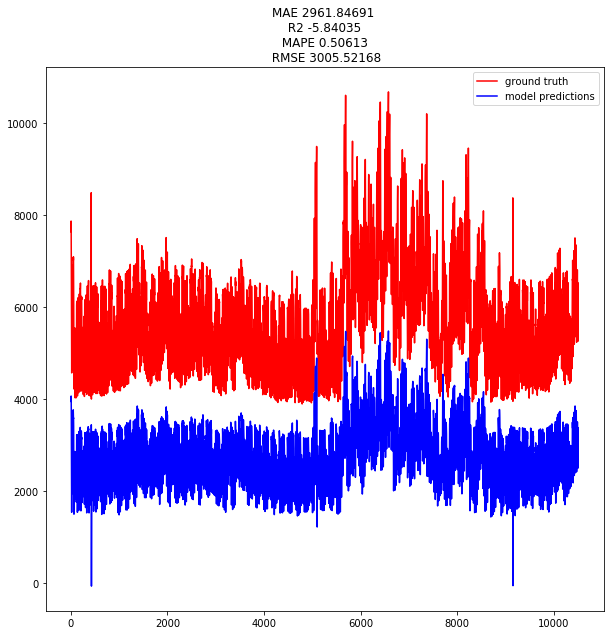

In [68]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [69]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 270.9832
R2 0.9430
RMSE 338.1347


In [70]:
lin_model.coef_

array([1.5881795], dtype=float32)

(10512,) (10512,)


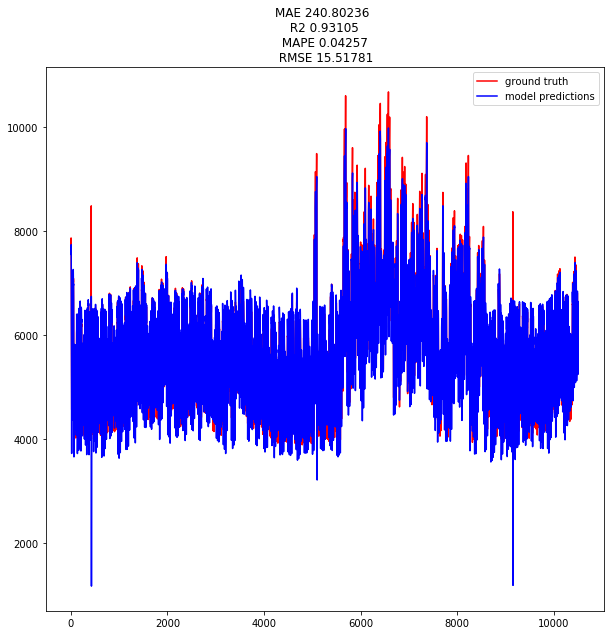

In [71]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [79]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

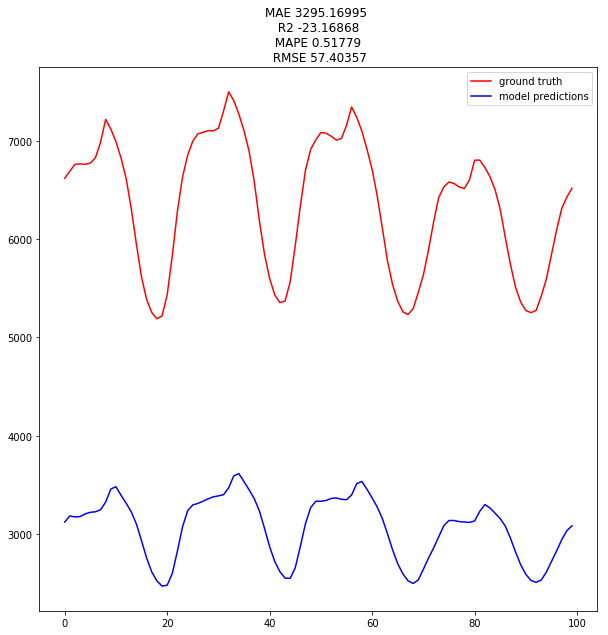

In [80]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [81]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 230.6254
R2 0.8342
RMSE 321.2585


In [82]:
lin_model.coef_

array([2.03733], dtype=float32)

(796,) (796,)


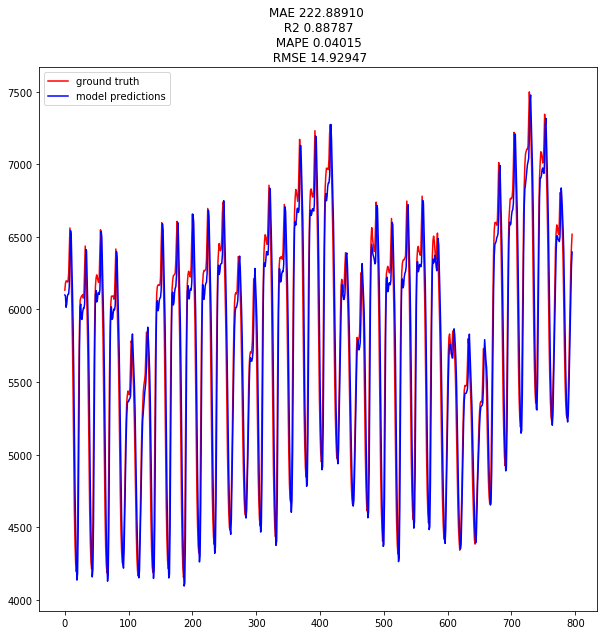

In [84]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [72]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/NYC Dataset combined lstm results.csv",sep=',')

In [88]:
#Pickling the history object.
pkl.dump(history,open('NYC.pkl','wb'))

## Stock data

In [98]:
stocks = ['AMZN','FB','WMT']
data = pd.read_csv("all_stocks_5yr.csv")
data = data[data['Name'] == stocks[2]][['close']].reset_index(drop=True)

In [95]:
amzn = data
#amzn[:] = (amzn[:] - amzn.min())/(amzn.max()-amzn.min() )

In [97]:
fb = data
#fb[:] = (fb[:] - fb.min())/(fb.max()-fb.min() )

In [99]:
wmt = data
#wmt[:] = (wmt[:] - wmt.min())/(wmt.max()-wmt.min() )

In [116]:
wmt.min() , wmt.max()

(close    56.42
 dtype: float64, close    109.55
 dtype: float64)

In [118]:
amzn.min() , amzn.max()

(close    248.23
 dtype: float64, close    1450.89
 dtype: float64)

In [137]:
fb.min() , fb.max()

(close    22.899
 dtype: float64, close    193.09
 dtype: float64)

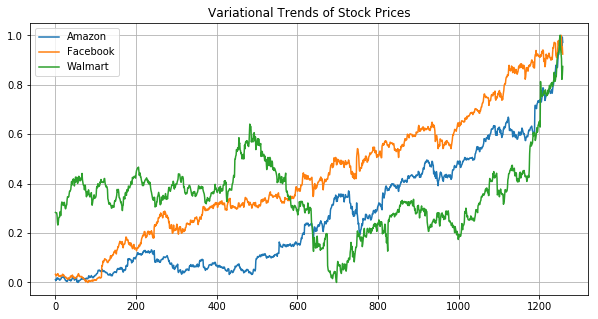

In [82]:
plt.figure(figsize=(10,5))
plt.title("Variational Trends of Stock Prices")
plt.plot(amzn)
plt.plot(fb)
plt.plot(wmt)
plt.grid(True)
plt.legend(["Amazon","Facebook","Walmart"])
plt.show()

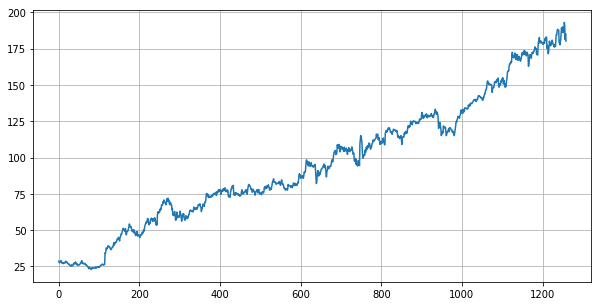

In [138]:
plt.figure(figsize=(10,5))
# plt.title("Walmart Stock Price Variations")
#plt.plot([np.mean(wmt)]*(wmt.shape[0]))
plt.plot(fb)
plt.grid(True)
plt.show()

In [242]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [243]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
history_callback = model.fit([past_train, fut_train], y_train, epochs=200, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_89 (Conv1D)              (None, 6, 256)       1536        input_45[0][0]                   
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 6, 256)       1536        input_46[0][0]                   
__________________________________________________________________________________________________
conv1d_90 

Train on 990 samples, validate on 248 samples
Epoch 1/200
990/990 [==============================] - 23s 23ms/step - loss: 29.7983 - mean_absolute_error: 30.2953 - rmse: 30.2953 - val_loss: 53.7629 - val_mean_absolute_error: 54.2629 - val_rmse: 54.2629
Epoch 2/200
990/990 [==============================] - 2s 2ms/step - loss: 6.6110 - mean_absolute_error: 7.0923 - rmse: 7.0923 - val_loss: 45.2296 - val_mean_absolute_error: 45.7296 - val_rmse: 45.7296
Epoch 3/200
990/990 [==============================] - 2s 2ms/step - loss: 11.0477 - mean_absolute_error: 11.5440 - rmse: 11.5440 - val_loss: 56.4213 - val_mean_absolute_error: 56.9213 - val_rmse: 56.9213
Epoch 4/200
990/990 [==============================] - 2s 2ms/step - loss: 6.5726 - mean_absolute_error: 7.0524 - rmse: 7.0524 - val_loss: 49.9130 - val_mean_absolute_error: 50.4130 - val_rmse: 50.4130
Epoch 5/200
990/990 [==============================] - 2s 2ms/step - loss: 3.1068 - mean_absolute_error: 3.5760 - rmse: 3.5760 - val_loss:

990/990 [==============================] - 2s 2ms/step - loss: 0.6353 - mean_absolute_error: 1.0370 - rmse: 1.0370 - val_loss: 49.7224 - val_mean_absolute_error: 50.2224 - val_rmse: 50.2224
Epoch 82/200
990/990 [==============================] - 2s 2ms/step - loss: 0.6118 - mean_absolute_error: 1.0134 - rmse: 1.0134 - val_loss: 49.6907 - val_mean_absolute_error: 50.1907 - val_rmse: 50.1907
Epoch 83/200
990/990 [==============================] - 2s 2ms/step - loss: 0.5772 - mean_absolute_error: 0.9666 - rmse: 0.9666 - val_loss: 49.5868 - val_mean_absolute_error: 50.0868 - val_rmse: 50.0868
Epoch 84/200
990/990 [==============================] - 2s 2ms/step - loss: 2.1816 - mean_absolute_error: 2.6369 - rmse: 2.6369 - val_loss: 46.8053 - val_mean_absolute_error: 47.3053 - val_rmse: 47.3053
Epoch 85/200
990/990 [==============================] - 2s 2ms/step - loss: 7.6343 - mean_absolute_error: 8.1292 - rmse: 8.1292 - val_loss: 46.7627 - val_mean_absolute_error: 47.2627 - val_rmse: 47.262

990/990 [==============================] - 2s 2ms/step - loss: 1.1489 - mean_absolute_error: 1.6066 - rmse: 1.6066 - val_loss: 49.7349 - val_mean_absolute_error: 50.2349 - val_rmse: 50.2349
Epoch 162/200
990/990 [==============================] - 2s 2ms/step - loss: 1.1797 - mean_absolute_error: 1.6222 - rmse: 1.6222 - val_loss: 47.5870 - val_mean_absolute_error: 48.0870 - val_rmse: 48.0870
Epoch 163/200
990/990 [==============================] - 2s 2ms/step - loss: 2.2680 - mean_absolute_error: 2.7413 - rmse: 2.7413 - val_loss: 44.5743 - val_mean_absolute_error: 45.0743 - val_rmse: 45.0743
Epoch 164/200
990/990 [==============================] - 2s 2ms/step - loss: 1.7458 - mean_absolute_error: 2.1755 - rmse: 2.1755 - val_loss: 48.9146 - val_mean_absolute_error: 49.4146 - val_rmse: 49.4146
Epoch 165/200
990/990 [==============================] - 2s 2ms/step - loss: 1.2641 - mean_absolute_error: 1.6709 - rmse: 1.6709 - val_loss: 50.3676 - val_mean_absolute_error: 50.8676 - val_rmse: 50

In [244]:
history = {}
for key in (history_callback.history.keys()):
    history[str(stock) + "_" + str(key)] = history_callback.history[str(key)]
    #print (key, " - ",history_callback.history[str(key)])

In [245]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

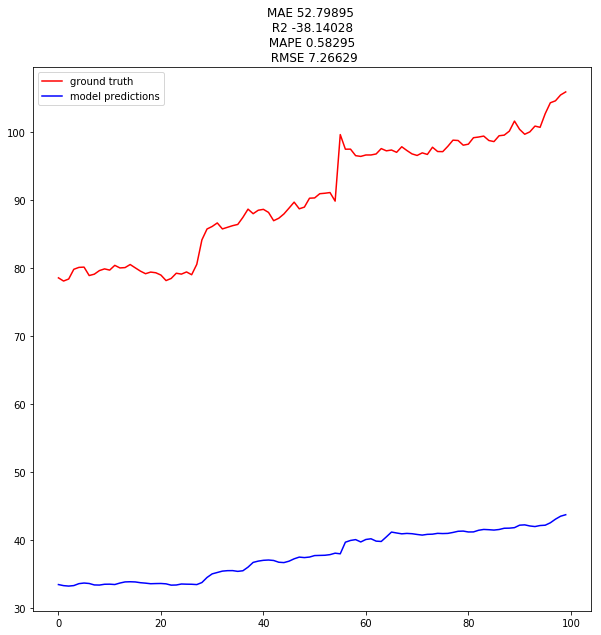

In [246]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [247]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.7536
R2 0.9358
RMSE 0.9845


In [248]:
lin_model.coef_

array([2.454898], dtype=float32)

(248,) (248,)


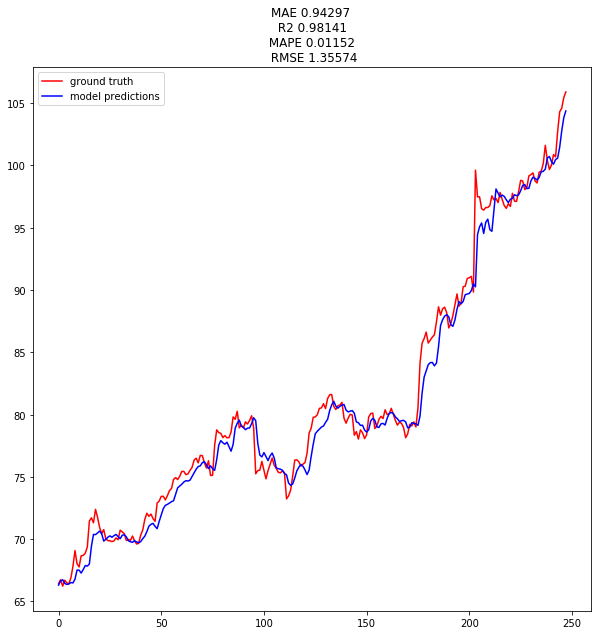

In [249]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [250]:
#Pickling the history object.
pkl.dump(history,open("Results/"+str(stocks[1])+'.pkl','wb'))

In [251]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/"+str(stocks[2])+"Dataset combined lstm results.csv",sep=',')

### Original

In [36]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       5376        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       5376        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 19s 19ms/step - loss: 319.3224 - mean_absolute_error: 319.8218 - val_loss: 202.1754 - val_mean_absolute_error: 202.6754
Epoch 2/20
990/990 [==============================] - 12s 13ms/step - loss: 176.6343 - mean_absolute_error: 177.1339 - val_loss: 540.5574 - val_mean_absolute_error: 541.0574
Epoch 3/20
990/990 [==============================] - 12s 12ms/step - loss: 113.6896 - mean_absolute_error: 114.1884 - val_loss: 496.9459 - val_mean_absolute_error: 497.4459
Epoch 4/20
990/990 [==============================] - 12s 12ms/step - loss: 36.8789 - mean_absolute_error: 37.3758 - val_loss: 596.8095 - val_mean_absolute_error: 597.3095
Epoch 5/20
990/990 [==============================] - 12s 12ms/step - loss: 31.3734 - mean_absolute_error: 31.8703 - val_loss: 507.3209 - val_mean_absolute_error: 507.8209
Epoch 6/20
990/990 [==============================] - 12s 12ms/step - loss: 81.0417 - me

In [98]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

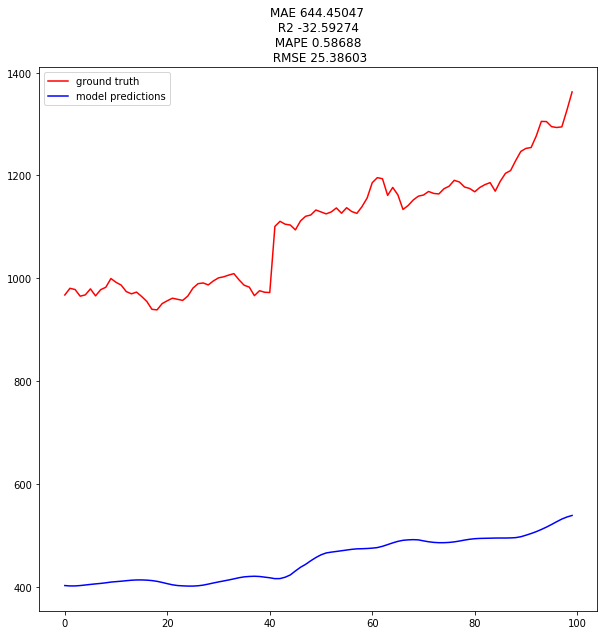

In [38]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [103]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 15.7086
R2 0.9453
RMSE 20.9191


In [40]:
lin_model.coef_

array([2.4861722], dtype=float32)

(248,) (248,)


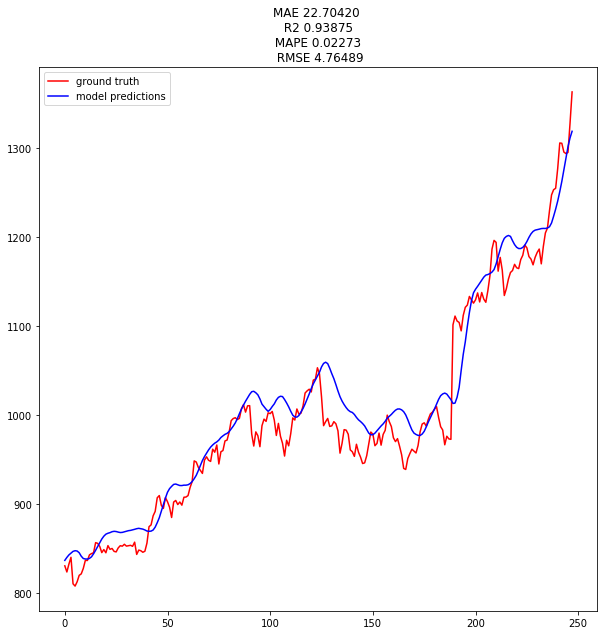

In [41]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

### Reduced further parameters

In [16]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model.fit([past_train, fut_train], y_train, epochs=150, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 6, 256)       5376        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 6, 256)       5376        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_10 

Train on 990 samples, validate on 248 samples
Epoch 1/150
990/990 [==============================] - 9s 9ms/step - loss: 167.3976 - mean_absolute_error: 167.8971 - val_loss: 395.4763 - val_mean_absolute_error: 395.9763
Epoch 2/150
990/990 [==============================] - 2s 2ms/step - loss: 107.3971 - mean_absolute_error: 107.8964 - val_loss: 488.3292 - val_mean_absolute_error: 488.8292
Epoch 3/150
990/990 [==============================] - 2s 2ms/step - loss: 48.5686 - mean_absolute_error: 49.0676 - val_loss: 638.6026 - val_mean_absolute_error: 639.1026
Epoch 4/150
990/990 [==============================] - 2s 2ms/step - loss: 40.3718 - mean_absolute_error: 40.8691 - val_loss: 598.9375 - val_mean_absolute_error: 599.4375
Epoch 5/150
990/990 [==============================] - 2s 2ms/step - loss: 67.4418 - mean_absolute_error: 67.9409 - val_loss: 625.9542 - val_mean_absolute_error: 626.4542
Epoch 6/150
990/990 [==============================] - 2s 2ms/step - loss: 44.3781 - mean_absol

Epoch 96/150
990/990 [==============================] - 2s 2ms/step - loss: 15.5144 - mean_absolute_error: 16.0060 - val_loss: 551.8750 - val_mean_absolute_error: 552.3750
Epoch 97/150
990/990 [==============================] - 2s 2ms/step - loss: 9.2683 - mean_absolute_error: 9.7591 - val_loss: 562.9285 - val_mean_absolute_error: 563.4285
Epoch 98/150
990/990 [==============================] - 2s 2ms/step - loss: 11.3208 - mean_absolute_error: 11.8116 - val_loss: 541.2987 - val_mean_absolute_error: 541.7987
Epoch 99/150
990/990 [==============================] - 2s 2ms/step - loss: 14.0611 - mean_absolute_error: 14.5557 - val_loss: 563.8071 - val_mean_absolute_error: 564.3071
Epoch 100/150
990/990 [==============================] - 2s 2ms/step - loss: 9.6803 - mean_absolute_error: 10.1674 - val_loss: 579.0979 - val_mean_absolute_error: 579.5979
Epoch 101/150
990/990 [==============================] - 2s 2ms/step - loss: 12.3397 - mean_absolute_error: 12.8293 - val_loss: 591.6138 - val

In [17]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

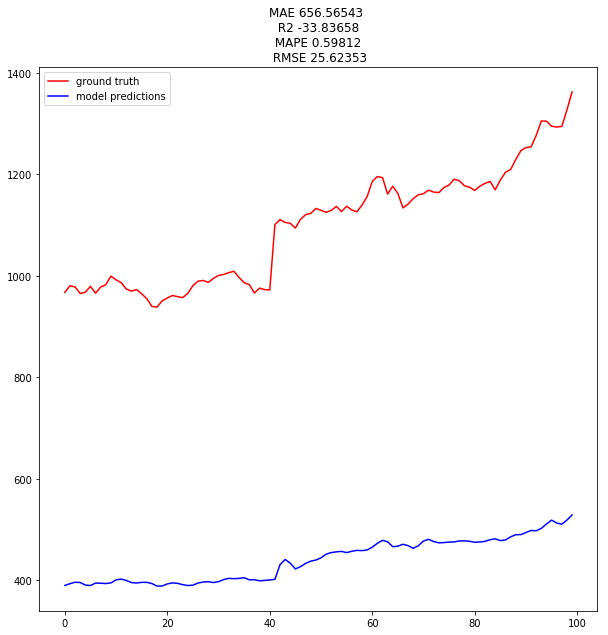

In [18]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [19]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 14.2327
R2 0.9549
RMSE 18.9989


In [20]:
lin_model.coef_

array([2.5332074], dtype=float32)

(248,) (248,)


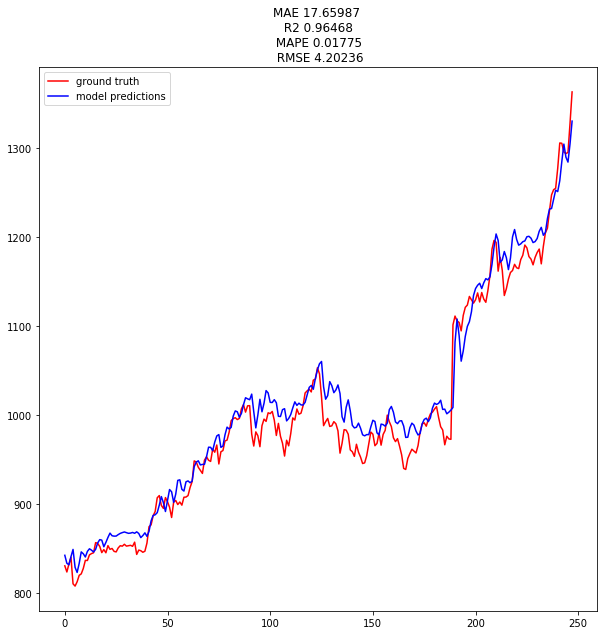

In [21]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Jena Weather Data

In [141]:
data = pd.read_csv("Jena_time_series_data.csv")['T (degC)']
# data = pd.read_csv("Jena_time_series_data.csv")
data.reset_index(drop=True,inplace=True)

In [142]:
data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),Tlog (degC),CO2 (ppm)
0,01.01.2008 00:10:00,1000.00,0.29,273.45,-0.77,92.50,6.24,5.77,0.47,3.60,5.77,1271.19,1.93,3.63,251.8,0.0,0,9.09,-9999.99
1,01.01.2008 00:20:00,999.94,0.24,273.40,-0.88,92.20,6.21,5.73,0.48,3.57,5.73,1271.40,2.34,3.13,256.4,0.0,0,9.12,-9999.99
2,01.01.2008 00:30:00,999.77,0.21,273.39,-0.91,92.10,6.20,5.71,0.49,3.56,5.71,1271.30,2.98,4.38,249.8,0.0,0,9.14,-9999.99
3,01.01.2008 00:40:00,999.71,0.17,273.35,-0.99,91.90,6.18,5.68,0.50,3.54,5.68,1271.45,3.37,4.88,256.5,0.0,0,9.13,-9999.99
4,01.01.2008 00:50:00,999.64,0.11,273.30,-1.08,91.70,6.16,5.64,0.51,3.52,5.65,1271.66,3.48,5.00,253.3,0.0,0,9.10,-9999.99
5,01.01.2008 01:00:00,999.63,0.10,273.29,-1.16,91.20,6.15,5.61,0.54,3.50,5.61,1271.70,3.68,4.88,255.0,0.0,0,9.04,-9999.99
6,01.01.2008 01:10:00,999.60,0.10,273.29,-1.23,90.70,6.15,5.58,0.57,3.48,5.58,1271.68,3.32,4.75,255.2,0.0,0,8.95,-9999.99
7,01.01.2008 01:20:00,999.53,0.07,273.27,-1.29,90.50,6.14,5.56,0.58,3.46,5.56,1271.73,3.62,4.75,252.8,0.0,0,8.85,-9999.99
8,01.01.2008 01:30:00,999.50,0.04,273.23,-1.36,90.30,6.12,5.53,0.59,3.45,5.53,1271.87,3.61,5.25,250.8,0.0,0,8.76,-9999.99
9,01.01.2008 01:40:00,999.45,0.03,273.23,-1.39,90.10,6.12,5.51,0.61,3.44,5.52,1271.84,3.90,4.88,250.4,0.0,0,8.67,-9999.99


In [42]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [43]:
# Results on temp. prediction.
model = common_lstm_model(past.shape[1:], fut.shape[1:])
history_callback = model.fit([past_train, fut_train], y_train, epochs=50, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 6, 256)       1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 6, 256)       1536        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_22 

Train on 1583 samples, validate on 396 samples
Epoch 1/50
1583/1583 [==============================] - 12s 8ms/step - loss: 1.1198 - mean_absolute_error: 1.4483 - val_loss: 2.3338 - val_mean_absolute_error: 2.7497
Epoch 2/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0410 - mean_absolute_error: 0.2134 - val_loss: 2.5097 - val_mean_absolute_error: 2.9385
Epoch 3/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0290 - mean_absolute_error: 0.1793 - val_loss: 2.1478 - val_mean_absolute_error: 2.5672
Epoch 4/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0871 - mean_absolute_error: 0.3266 - val_loss: 2.2287 - val_mean_absolute_error: 2.6488
Epoch 5/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0402 - mean_absolute_error: 0.2038 - val_loss: 2.1308 - val_mean_absolute_error: 2.5466
Epoch 6/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1533 - val_los

Epoch 50/50
1583/1583 [==============================] - 4s 2ms/step - loss: 0.0050 - mean_absolute_error: 0.0762 - val_loss: 2.3670 - val_mean_absolute_error: 2.7889


In [ ]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]
    print (key, " - ",history_callback.history[str(key)])

In [44]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

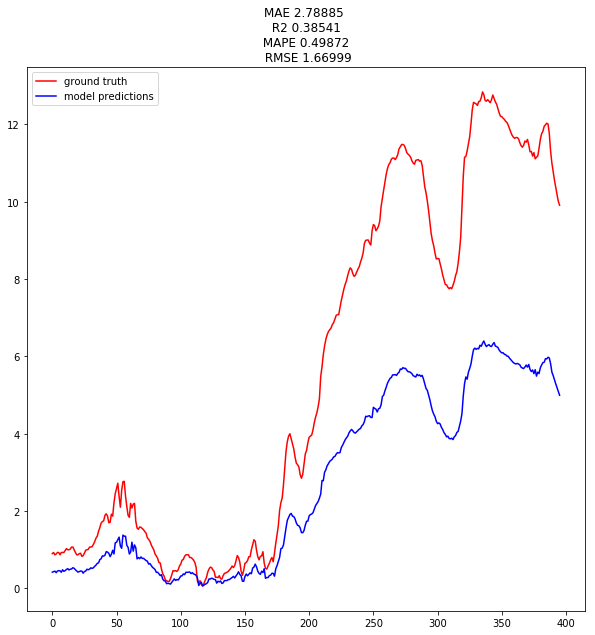

In [45]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [46]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.1236
R2 0.9919
RMSE 0.1759


In [47]:
lin_model.coef_

array([2.0027401], dtype=float32)

(396,) (396,)


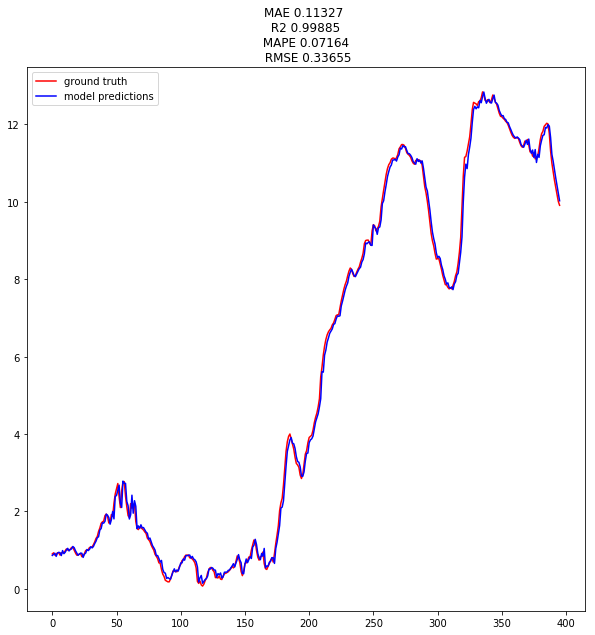

In [48]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [22]:
# Results on temp. prediction.
model = common_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 6, 256)       1536        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 6, 256)       1536        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_10 

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 27s 17ms/step - loss: 1.4403 - mean_absolute_error: 1.7978 - val_loss: 2.7157 - val_mean_absolute_error: 3.1334
Epoch 2/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.0923 - mean_absolute_error: 0.3257 - val_loss: 2.6180 - val_mean_absolute_error: 3.0444
Epoch 3/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.0572 - mean_absolute_error: 0.2402 - val_loss: 2.3875 - val_mean_absolute_error: 2.8120
Epoch 4/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.1111 - mean_absolute_error: 0.3334 - val_loss: 2.1288 - val_mean_absolute_error: 2.5408
Epoch 5/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1774 - val_loss: 2.3343 - val_mean_absolute_error: 2.7589
Epoch 6/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.0355 - mean_absolute_error: 0.196

In [26]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

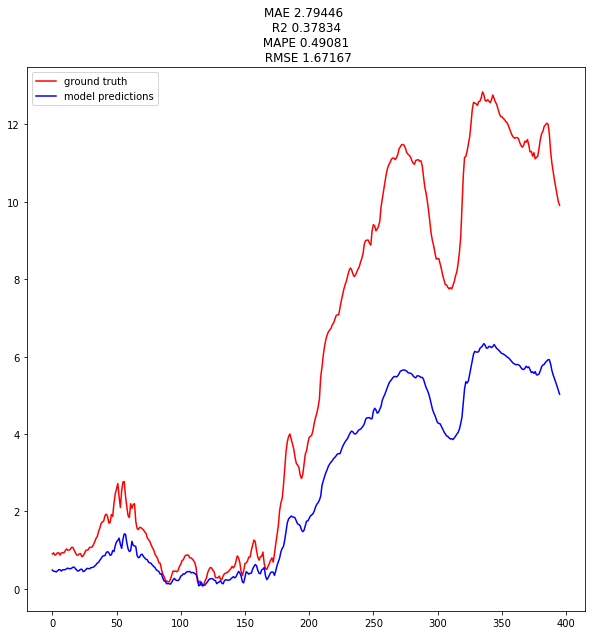

In [32]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [25]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.1679
R2 0.9857
RMSE 0.2334


In [33]:
lin_model.coef_

array([2.0245867], dtype=float32)

(396,) (396,)


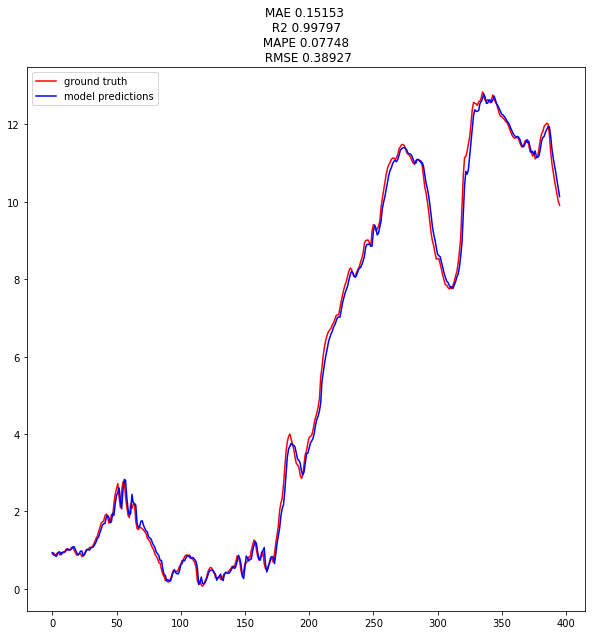

In [26]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [28]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Jena Dataset combined lstm results.csv",sep=',')

## Zuerich Sunspot Data 

In [11]:
data = pd.read_csv("monthly-sunspot-number-zurich-17.csv")['Monthly sunspot number, Zurich, 1749-1983']

In [12]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [13]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,past_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       1536        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 2239 samples, validate on 560 samples
Epoch 1/20
2239/2239 [==============================] - 34s 15ms/step - loss: 18.9571 - mean_absolute_error: 19.4459 - val_loss: 18.3729 - val_mean_absolute_error: 18.8646
Epoch 2/20
2239/2239 [==============================] - 28s 12ms/step - loss: 12.2866 - mean_absolute_error: 12.7706 - val_loss: 14.9853 - val_mean_absolute_error: 15.4772
Epoch 3/20
2239/2239 [==============================] - 28s 12ms/step - loss: 11.5384 - mean_absolute_error: 12.0208 - val_loss: 24.1609 - val_mean_absolute_error: 24.6555
Epoch 4/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.9738 - mean_absolute_error: 10.4538 - val_loss: 14.5706 - val_mean_absolute_error: 15.0609
Epoch 5/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.9077 - mean_absolute_error: 10.3887 - val_loss: 18.7969 - val_mean_absolute_error: 19.2923
Epoch 6/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.7746 - mean_abs

In [14]:
pred = model.predict([past_test, past_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

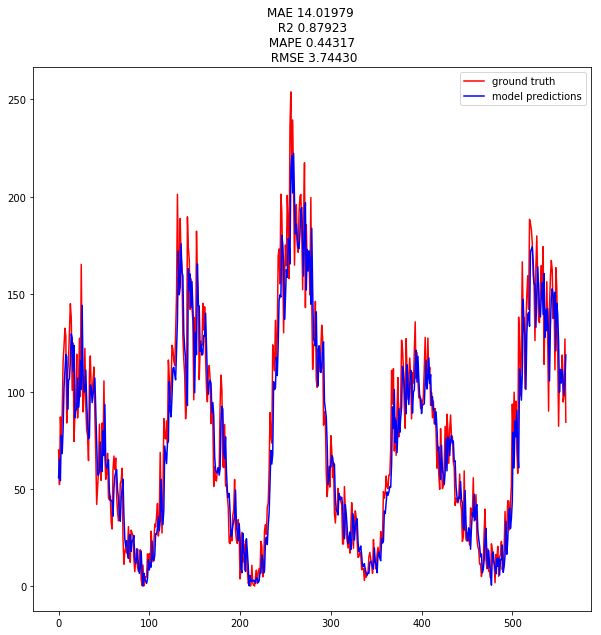

In [15]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [16]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 10.7994
R2 0.7616
RMSE 14.3835


(560,) (560,)


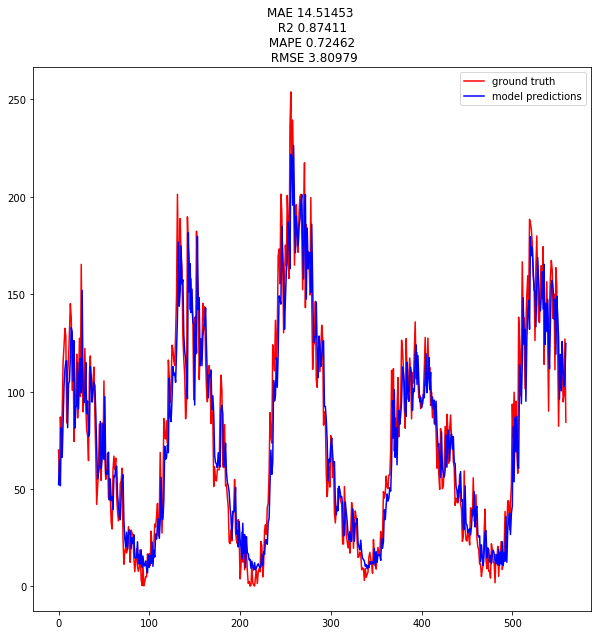

In [17]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [19]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Zurich sunspot Dataset combined lstm results.csv",sep=',')

## Petroleum Weekly prices Data

In [42]:
data = pd.read_csv("petroleumWeeklyPrices.csv").iloc[:,1]

In [44]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [46]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 6, 256)       1536        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 6, 256)       1536        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_18 

Train on 1032 samples, validate on 259 samples
Epoch 1/20
1032/1032 [==============================] - 21s 20ms/step - loss: 1.1633 - mean_absolute_error: 1.4323 - val_loss: 1.2768 - val_mean_absolute_error: 1.7768
Epoch 2/20
1032/1032 [==============================] - 13s 12ms/step - loss: 0.0155 - mean_absolute_error: 0.1276 - val_loss: 0.9325 - val_mean_absolute_error: 1.4323
Epoch 3/20
1032/1032 [==============================] - 13s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1518 - val_loss: 0.9018 - val_mean_absolute_error: 1.4014
Epoch 4/20
1032/1032 [==============================] - 13s 12ms/step - loss: 0.0068 - mean_absolute_error: 0.0838 - val_loss: 0.8848 - val_mean_absolute_error: 1.3845
Epoch 5/20
1032/1032 [==============================] - 13s 12ms/step - loss: 0.0064 - mean_absolute_error: 0.0783 - val_loss: 0.9449 - val_mean_absolute_error: 1.4448
Epoch 6/20
1032/1032 [==============================] - 13s 12ms/step - loss: 0.0085 - mean_absolute_error: 0.097

In [47]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

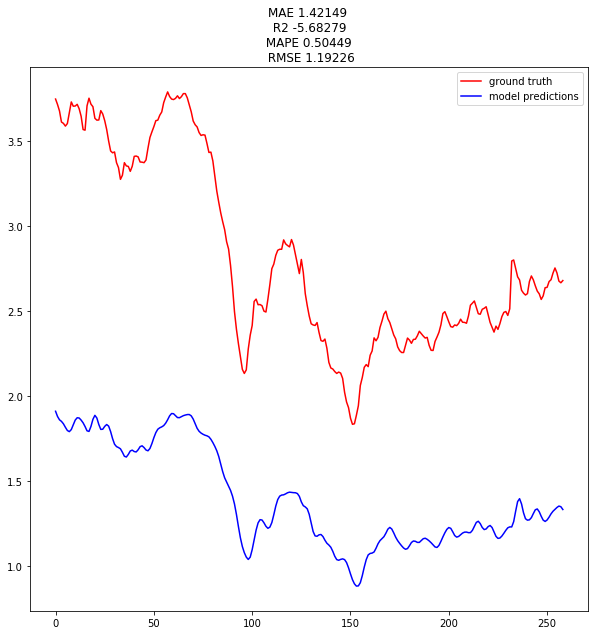

In [48]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [49]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.0890
R2 0.9546
RMSE 0.1224


(259,) (259,)


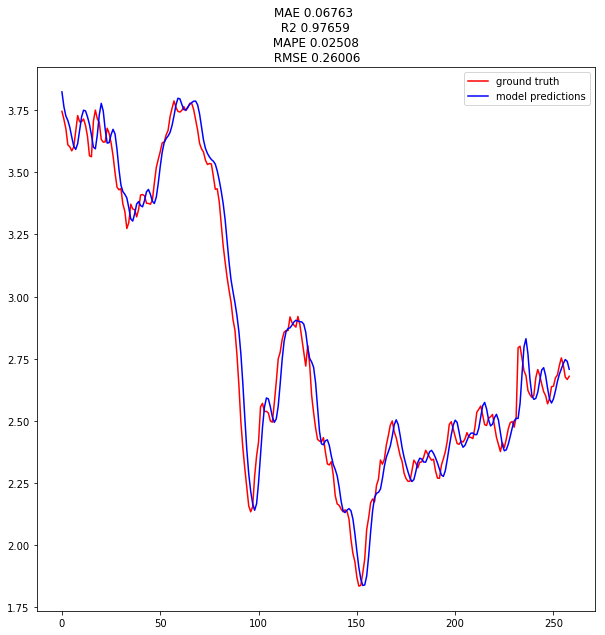

In [50]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [51]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Petroleum prices Dataset combined lstm results.csv",sep=',')

## Monthly car sales Data

In [67]:
data = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")["Monthly car sales in Quebec 1960-1968"]

In [68]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [80]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=500, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 6, 256)       1536        input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 6, 256)       1536        input_20[0][0]                   
__________________________________________________________________________________________________
conv1d_38 

Train on 70 samples, validate on 18 samples
Epoch 1/500
70/70 [==============================] - 14s 193ms/step - loss: 14293.5026 - mean_absolute_error: 14294.0026 - val_loss: 14396.5342 - val_mean_absolute_error: 14397.0342
Epoch 2/500
70/70 [==============================] - 1s 16ms/step - loss: 10100.1966 - mean_absolute_error: 10100.6966 - val_loss: 16271.6182 - val_mean_absolute_error: 16272.1182
Epoch 3/500
70/70 [==============================] - 1s 16ms/step - loss: 13090.6118 - mean_absolute_error: 13091.1118 - val_loss: 16084.8887 - val_mean_absolute_error: 16085.3887
Epoch 4/500
70/70 [==============================] - 1s 16ms/step - loss: 11928.4071 - mean_absolute_error: 11928.9071 - val_loss: 11151.5352 - val_mean_absolute_error: 11152.0352
Epoch 5/500
70/70 [==============================] - 1s 16ms/step - loss: 7014.5236 - mean_absolute_error: 7015.0236 - val_loss: 9119.6992 - val_mean_absolute_error: 9120.1992
Epoch 6/500
70/70 [==============================] - 1s 16

Epoch 47/500
70/70 [==============================] - 1s 16ms/step - loss: 1378.5975 - mean_absolute_error: 1379.0975 - val_loss: 8342.6904 - val_mean_absolute_error: 8343.1904
Epoch 48/500
70/70 [==============================] - 1s 16ms/step - loss: 1762.3766 - mean_absolute_error: 1762.8766 - val_loss: 10180.6826 - val_mean_absolute_error: 10181.1826
Epoch 49/500
70/70 [==============================] - 1s 16ms/step - loss: 1988.3582 - mean_absolute_error: 1988.8582 - val_loss: 6622.6021 - val_mean_absolute_error: 6623.1021
Epoch 50/500
70/70 [==============================] - 1s 16ms/step - loss: 2879.5794 - mean_absolute_error: 2880.0794 - val_loss: 10466.4414 - val_mean_absolute_error: 10466.9414
Epoch 51/500
70/70 [==============================] - 1s 16ms/step - loss: 2466.1876 - mean_absolute_error: 2466.6876 - val_loss: 7523.3462 - val_mean_absolute_error: 7523.8462
Epoch 52/500
70/70 [==============================] - 1s 16ms/step - loss: 2076.2936 - mean_absolute_error: 207

70/70 [==============================] - 1s 16ms/step - loss: 1210.2920 - mean_absolute_error: 1210.7920 - val_loss: 7583.3223 - val_mean_absolute_error: 7583.8223
Epoch 140/500
70/70 [==============================] - 1s 16ms/step - loss: 984.5575 - mean_absolute_error: 985.0575 - val_loss: 8266.0166 - val_mean_absolute_error: 8266.5166
Epoch 141/500
70/70 [==============================] - 1s 16ms/step - loss: 899.8317 - mean_absolute_error: 900.3317 - val_loss: 7941.3228 - val_mean_absolute_error: 7941.8228
Epoch 142/500
70/70 [==============================] - 1s 16ms/step - loss: 1088.7962 - mean_absolute_error: 1089.2962 - val_loss: 9056.5859 - val_mean_absolute_error: 9057.0859
Epoch 143/500
70/70 [==============================] - 1s 16ms/step - loss: 1930.8249 - mean_absolute_error: 1931.3249 - val_loss: 7579.2510 - val_mean_absolute_error: 7579.7510
Epoch 144/500
70/70 [==============================] - 1s 16ms/step - loss: 1278.6166 - mean_absolute_error: 1279.1166 - val_los

70/70 [==============================] - 1s 16ms/step - loss: 956.4652 - mean_absolute_error: 956.9652 - val_loss: 8002.2432 - val_mean_absolute_error: 8002.7432
Epoch 232/500
70/70 [==============================] - 1s 16ms/step - loss: 870.8827 - mean_absolute_error: 871.3827 - val_loss: 8562.2666 - val_mean_absolute_error: 8562.7666
Epoch 233/500
70/70 [==============================] - 1s 16ms/step - loss: 750.5259 - mean_absolute_error: 751.0224 - val_loss: 8116.2456 - val_mean_absolute_error: 8116.7456
Epoch 234/500
70/70 [==============================] - 1s 16ms/step - loss: 784.5968 - mean_absolute_error: 785.0911 - val_loss: 8104.6094 - val_mean_absolute_error: 8105.1094
Epoch 235/500
70/70 [==============================] - 1s 16ms/step - loss: 716.9925 - mean_absolute_error: 717.4925 - val_loss: 8937.8770 - val_mean_absolute_error: 8938.3770
Epoch 236/500
70/70 [==============================] - 1s 16ms/step - loss: 1299.8468 - mean_absolute_error: 1300.3468 - val_loss: 726

70/70 [==============================] - 1s 16ms/step - loss: 1147.0185 - mean_absolute_error: 1147.5185 - val_loss: 8093.5449 - val_mean_absolute_error: 8094.0449
Epoch 324/500
70/70 [==============================] - 1s 16ms/step - loss: 991.4623 - mean_absolute_error: 991.9623 - val_loss: 7157.5132 - val_mean_absolute_error: 7158.0132
Epoch 325/500
70/70 [==============================] - 1s 16ms/step - loss: 1370.6507 - mean_absolute_error: 1371.1507 - val_loss: 7977.0806 - val_mean_absolute_error: 7977.5806
Epoch 326/500
70/70 [==============================] - 1s 16ms/step - loss: 1108.5420 - mean_absolute_error: 1109.0420 - val_loss: 8465.4160 - val_mean_absolute_error: 8465.9160
Epoch 327/500
70/70 [==============================] - 1s 16ms/step - loss: 837.4503 - mean_absolute_error: 837.9503 - val_loss: 7106.1182 - val_mean_absolute_error: 7106.6182
Epoch 328/500
70/70 [==============================] - 1s 16ms/step - loss: 1322.3127 - mean_absolute_error: 1322.8127 - val_los

70/70 [==============================] - 1s 16ms/step - loss: 840.8779 - mean_absolute_error: 841.3779 - val_loss: 7311.7041 - val_mean_absolute_error: 7312.2041
Epoch 416/500
70/70 [==============================] - 1s 16ms/step - loss: 895.7198 - mean_absolute_error: 896.2198 - val_loss: 8242.0566 - val_mean_absolute_error: 8242.5566
Epoch 417/500
70/70 [==============================] - 1s 16ms/step - loss: 1022.9949 - mean_absolute_error: 1023.4949 - val_loss: 7648.5391 - val_mean_absolute_error: 7649.0391
Epoch 418/500
70/70 [==============================] - 1s 16ms/step - loss: 585.3079 - mean_absolute_error: 585.8079 - val_loss: 8079.6069 - val_mean_absolute_error: 8080.1069
Epoch 419/500
70/70 [==============================] - 1s 16ms/step - loss: 640.0290 - mean_absolute_error: 640.5290 - val_loss: 7669.8994 - val_mean_absolute_error: 7670.3994
Epoch 420/500
70/70 [==============================] - 1s 16ms/step - loss: 576.8030 - mean_absolute_error: 577.3030 - val_loss: 774

In [81]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

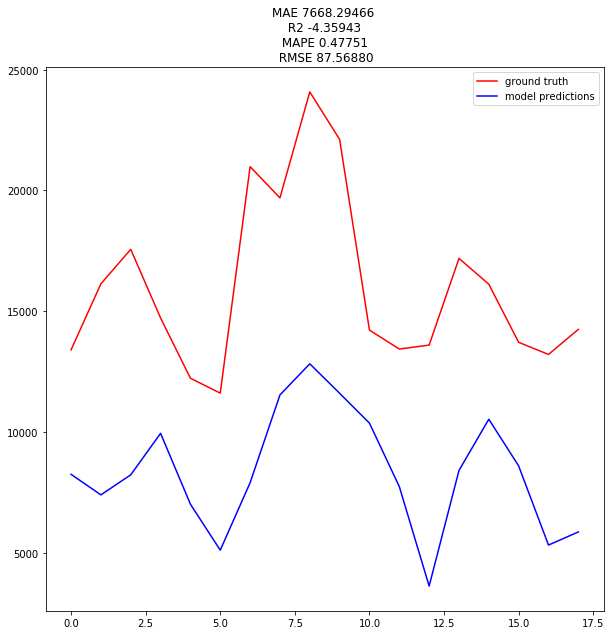

In [82]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [83]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 1775.2556
R2 0.7033
RMSE 2134.4831


(18,) (18,)


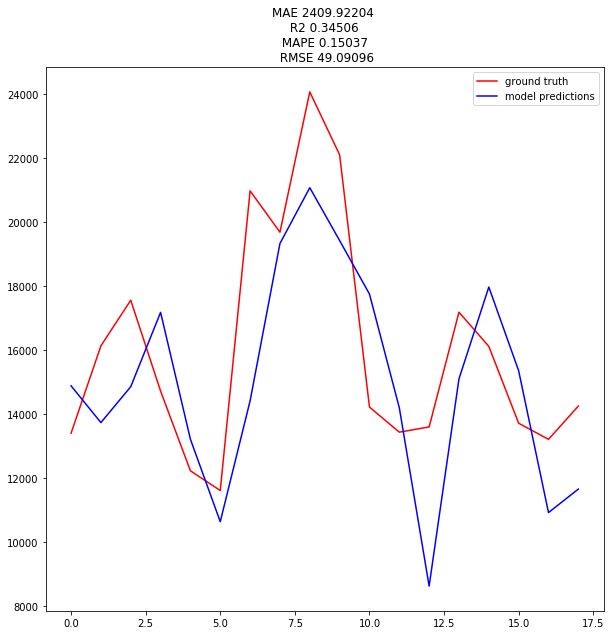

In [84]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [85]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Car Sales Dataset combined lstm results.csv",sep=',')

## Wolfer Sunspot Data

In [ ]:
data = pd.read_csv("wolfer-sunspot-numbers-1770-to-1.csv")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Car Sales Dataset combined lstm results.csv",sep=',')

## Daily Minimum temperature Data

In [ ]:
data = pd.read_csv("daily_minimum")

In [ ]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y)

In [ ]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()